# Task Bモデルの評価  
訓練データにないコレクションに対する評価をする．  

総データ60000程度，そのうち2000程度のコレクションをテストデータとして用いる（すべてデータ内に1つしかないコレクション）．  

In [1]:
from comet_ml import Experiment

import os
import sys
import gc
import warnings

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm
import lightgbm as lgb
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.losses as losses
import tensorflow.keras.optimizers as optim
import tensorflow.keras.activations as activations
import matplotlib.pyplot as plt

sys.path.append('../src')
sys.path.append('../Swin-Transformer-TF')
from ml_utils import *
from utils import *
from swintransformer import SwinTransformer

warnings.filterwarnings('ignore')
pd.options.display.max_columns = 200
pd.options.display.max_rows = 20


%matplotlib inline

In [2]:
DIR = "../data/taskB/table"
IMG_DIR = "../data/taskB/img"

df = pd.read_csv(os.path.join(DIR, "events_data.csv"))
df['full_path'] = df['image_id'].apply(lambda x: IMG_DIR+'/'+x)
df = df.rename(columns={'total_price': 'target'})

df['target'] = df['target'].astype(float).apply(lambda x: np.log1p(x * 1e-18))
df = df.query("target > 0").reset_index(drop=True)

df.head()

,approved_account,asset_bundle,auction_type,bid_amount,collection_slug,contract_address,created_date,custom_event_name,dev_fee_payment_event,dev_seller_fee_basis_points,duration,ending_price,event_type,from_account,id,is_private,owner_account,quantity,starting_price,to_account,target,listing_time,asset.id,asset.token_id,asset.num_sales,asset.background_color,asset.image_url,asset.image_preview_url,asset.image_thumbnail_url,asset.image_original_url,asset.animation_url,asset.animation_original_url,asset.name,asset.description,asset.external_link,asset.asset_contract.address,asset.asset_contract.asset_contract_type,asset.asset_contract.created_date,asset.asset_contract.name,asset.asset_contract.nft_version,asset.asset_contract.opensea_version,asset.asset_contract.owner,asset.asset_contract.schema_name,asset.asset_contract.symbol,asset.asset_contract.total_supply,asset.asset_contract.description,asset.asset_contract.external_link,asset.asset_contract.image_url,asset.asset_contract.default_to_fiat,asset.asset_contract.dev_buyer_fee_basis_points,asset.asset_contract.dev_seller_fee_basis_points,asset.asset_contract.only_proxied_transfers,asset.asset_contract.opensea_buyer_fee_basis_points,asset.asset_contract.opensea_seller_fee_basis_points,asset.asset_contract.buyer_fee_basis_points,asset.asset_contract.seller_fee_basis_points,asset.asset_contract.payout_address,asset.permalink,asset.collection.banner_image_url,asset.collection.chat_url,asset.collection.created_date,asset.collection.default_to_fiat,asset.collection.description,asset.collection.dev_buyer_fee_basis_points,asset.collection.dev_seller_fee_basis_points,asset.collection.discord_url,asset.collection.display_data.card_display_style,asset.collection.display_data.images,asset.collection.external_url,asset.collection.featured,asset.collection.featured_image_url,asset.collection.hidden,asset.collection.safelist_request_status,asset.collection.image_url,asset.collection.is_subject_to_whitelist,asset.collection.large_image_url,asset.collection.medium_username,asset.collection.name,asset.collection.only_proxied_transfers,asset.collection.opensea_buyer_fee_basis_points,asset.collection.opensea_seller_fee_basis_points,asset.collection.payout_address,asset.collection.require_email,asset.collection.short_description,asset.collection.slug,asset.collection.telegram_url,asset.collection.twitter_username,asset.collection.instagram_username,asset.collection.wiki_url,asset.decimals,asset.token_metadata,asset.owner.user.username,asset.owner.profile_img_url,asset.owner.address,asset.owner.config,payment_token.id,payment_token.symbol,payment_token.address,payment_token.image_url,payment_token.name,...,dev_fee_payment_event.transaction.block_hash,dev_fee_payment_event.transaction.block_number,dev_fee_payment_event.transaction.from_account.user.username,dev_fee_payment_event.transaction.from_account.profile_img_url,dev_fee_payment_event.transaction.from_account.address,dev_fee_payment_event.transaction.from_account.config,dev_fee_payment_event.transaction.id,dev_fee_payment_event.transaction.timestamp,dev_fee_payment_event.transaction.to_account.user.username,dev_fee_payment_event.transaction.to_account.profile_img_url,dev_fee_payment_event.transaction.to_account.address,dev_fee_payment_event.transaction.to_account.config,dev_fee_payment_event.transaction.transaction_hash,dev_fee_payment_event.transaction.transaction_index,dev_fee_payment_event.created_date,dev_fee_payment_event.quantity,dev_fee_payment_event.transaction.from_account,dev_fee_payment_event.transaction.to_account,asset,asset_bundle.maker.user.username,asset_bundle.maker.profile_img_url,asset_bundle.maker.address,asset_bundle.maker.config,asset_bundle.slug,asset_bundle.assets,asset_bundle.name,asset_bundle.description,asset_bundle.external_link,asset_bundle.asset_contract.collection.banner_image_url,asset_bundle.asset_contract.collection.chat_url,asset_bundle.asset_contract.collection.created_date,asset_bundle.asset_contract.collec

In [3]:
experiment = Experiment(
    api_key=get_comet_ml_key(),
    project_name="nft-appraiser",
    workspace="nft-appraiser",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/nft-appraiser/nft-appraiser/92318de4265046c18f6bc159f751e956



In [4]:
# テスト用のコレクションデータを決める
# テスト用のコレクションが2000，データ数としても2000になっている．
count_df = pd.DataFrame(df['asset.collection.name'].value_counts())
count_df['collection_name'] = count_df.index.values
count_df = count_df.rename(columns={"asset.collection.name": "data_count"}).iloc[::-1, :].reset_index(drop=True)
count_df['data_cumsum'] = count_df['data_count'].cumsum()
count_df

test_collections = count_df.query("data_cumsum <= 2000")['collection_name'].values

**学習の推移を見ると過学習しているように見える**．  

In [5]:
# テストデータかどうかフラグをつける（1はテストデータ）
df['test_flag'] = df['asset.collection.name'].isin(test_collections).astype(int).values

train_df = df.query("test_flag == 0")
test_df = df.query("test_flag == 1")

train_path_list = train_df['full_path'].values
train_y = train_df['target'].values

test_path_list = test_df['full_path'].values
test_y = test_df['target'].values

model_B = train(train_path_list, train_y, losses.mean_squared_error)

2022-01-11 04:21:18.300874: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 04:21:18.373873: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 04:21:18.375584: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 04:21:18.377904: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

starting training
*------------------------------*
Epoch 1/100


2022-01-11 04:21:22.667334: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
COMET INFO: ignoring tensorflow summary log of metrics because of keras; set `comet_ml.loggers.tensorboard_logger.LOG_METRICS = True` to override
2022-01-11 04:21:31.784856: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204
2022-01-11 04:21:34.134389: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3310/3310 [==============================] - 966s 288ms/step - loss: 0.7219 - mae: 0.3496 - mse: 0.7219 - val_loss: 0.4584 - val_mae: 0.2561 - val_mse: 0.4584
Epoch 2/100
3310/3310 [==============================] - 965s 292ms/step - loss: 0.5744 - mae: 0.3062 - mse: 0.5744 - val_loss: 0.4530 - val_mae: 0.2777 - val_mse: 0.4530
Epoch 3/100
3310/3310 [==============================] - 943s 285ms/step - loss: 0.5184 - mae: 0.2891 - mse: 0.5184 - val_loss: 0.3698 - val_mae: 0.2305 - val_mse: 0.3698
Epoch 4/100
3310/3310 [==============================] - 924s 279ms/step - loss: 0.4679 - mae: 0.2742 - mse: 0.4679 - val_loss: 0.3884 - val_mae: 0.2405 - val_mse: 0.3884
Epoch 5/100
3310/3310 [==============================] - 913s 276ms/step - loss: 0.4207 - mae: 0.2591 - mse: 0.4207 - val_loss: 0.3513 - val_mae: 0.2404 - val_mse: 0.3513
Epoch 6/100
3310/3310 [==============================] - 923s 279ms/step - loss: 0.3731 - mae: 0.2450 - mse: 0.3731 - val_loss: 0.3492 - val_mae: 0.2138 - va

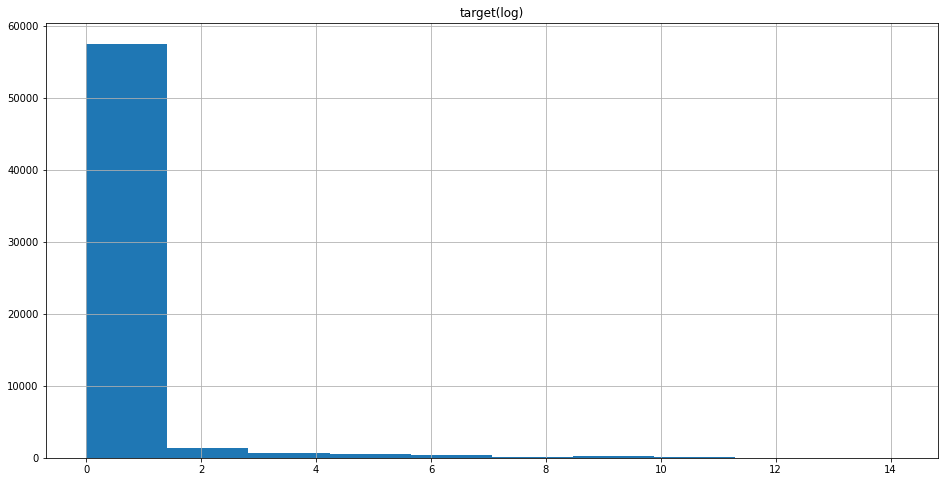

In [6]:
plt.figure(figsize=(16, 8))
plt.hist(df['target'])
plt.title("target(log)")
plt.grid(True)
plt.show()

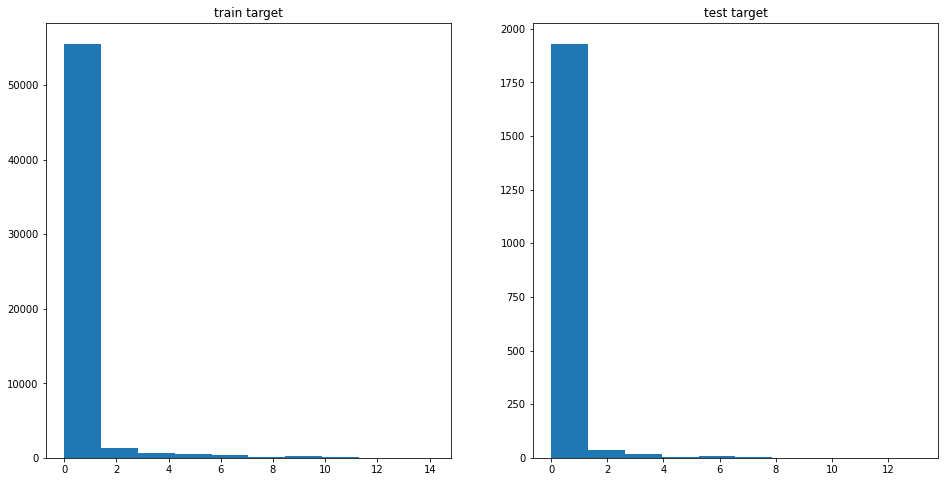

In [14]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
ax = ax.flatten()
ax[0].hist(train_df['target'])
ax[0].set_title("train target")
ax[1].hist(test_df['target'])
ax[1].set_title("test target")
plt.show()

In [7]:
print(f"Target mean: {df['target'].mean()}")
print(f"Target std: {df['target'].std()}")

Target mean: 0.36961143966009113
Target std: 1.1475190134248736


In [8]:
test_data_gen = FullPathDataLoader(path_list=test_path_list, target=test_y,
                                   batch_size=1, task="B",
                                   width=224, height=224, shuffle=False, is_train=False)
pred = model_B.model.predict(test_data_gen)
rmse_score = np.sqrt(mean_squared_error(test_y, pred))
mae_score = mean_absolute_error(test_y, pred)

print(f"Test RMSE Score: {rmse_score}")
print(f"Test MAE Score: {mae_score}")

Test RMSE Score: 0.7860715450500063
Test MAE Score: 0.348785338522558


### 残差プロット  
**全体的に過小評価されている**．  

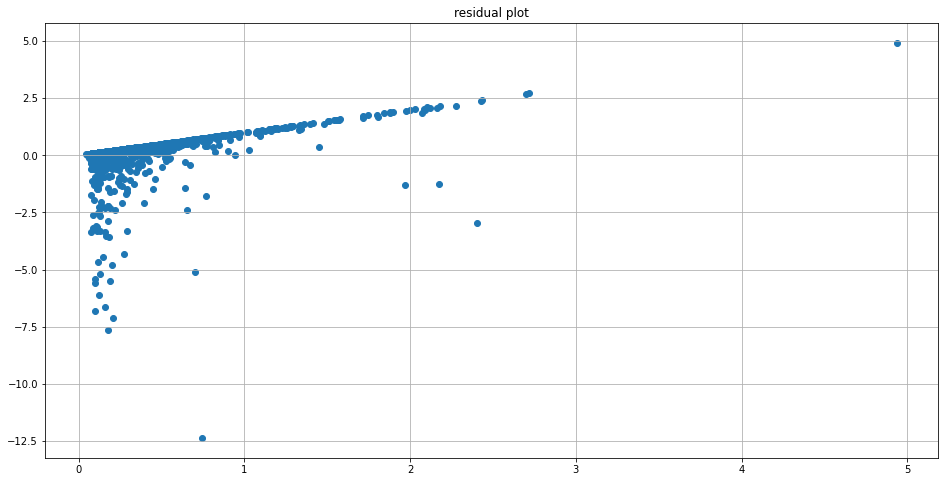

In [37]:
residual = pred.reshape(-1) - test_y

plt.figure(figsize=(16, 8))
plt.scatter(pred.reshape(-1), residual)
plt.title("residual plot")
plt.grid(True)
plt.show()

In [9]:
metrics = {"test_rmse": round(rmse_score, 3), "test__mae": round(mae_score, 3)}
experiment.log_metrics(metrics)

In [10]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/nft-appraiser/nft-appraiser/92318de4265046c18f6bc159f751e956
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     batch_loss [11585]          : (0.002204893622547388, 1.475640892982483)
COMET INFO:     batch_mae [11585]           : (0.04084734618663788, 0.5240265727043152)
COMET INFO:     batch_mse [11585]           : (0.002204893622547388, 1.475640892982483)
COMET INFO:     epoch_duration [35]         : (844.6113462310022, 965.8425311849996)
COMET INFO:     loss [35]                   : (0.13827699422836304, 0.7219098806381226)
COMET INFO:     mae [35]                    : (0.1486314833164215, 0.34959617257118225)
COMET INFO:     mse [35]                    : (0.13827699422836304, 0.7219098806381226)
COMET INFO:     test__mae                